In [22]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import statistics
import collections


In [4]:
prices_df = pd.read_csv('filtered_data.csv', index_col = 0)
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df.head()

,Date,ASTS,ASTSW,NPAUU,INVZ,INVZW,CGROU,FOA,FOA/WS,RPLA/U,...,HYACU,ASLE,ASLEW,MNCLU,XL,GOEV,GOEVW,CLVR,CLVRW,SAMAU
1,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
def nearest(possible_values, value):
    return min(possible_values, key=lambda x: abs(x - value))

def unique(list1): 
    # intilize a null list 
    unique_list = [] 
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x)
    return unique_list

In [5]:
# params: prices_df is the dataframe with spac prices
# ticker is a string of the ticker desired
# date is a datetime or string that is the desired trade date
# function will get price for a ticker on a specific date from prices_df
# If the date is not in the file (ex: a weekend), it'll look for the nearest date and use that instead (it'll print to console if this happens)
def get_price(prices_df, ticker, date):
    date = pd.to_datetime(date)
    trading_days= list(prices_df[['Date',ticker]].dropna(axis = 0)['Date'].values)
    if date in trading_days:
        trade_date = date
    else:
        trade_date = nearest(trading_days, date)
        trade_date = pd.to_datetime(trade_date)
        print(f'{date.date()} not in data, so {trade_date.date()} used instead')
    date_filter = (prices_df['Date'] ==  trade_date)
    price = prices_df[date_filter][ticker].values[0]
    print(ticker, trade_date, price)
    return price

# Testing it out
ticker = 'INVZ'
date = '2020-12-18'
get_price(prices_df, ticker, date)

INVZ 2020-12-18 00:00:00 11.6


11.6

In [6]:
announcements_df = pd.read_csv('filtered_announced_data.csv', index_col = 0)
announcements_df['Announced'] = pd.to_datetime(announcements_df['Announced'])
announcements_df['Closed'] = pd.to_datetime(announcements_df['Closed'])
announcements_df.head()

,Ticker,Announced,Closed
0,ASTS,2020-12-16,2021-04-06
1,INVZ,2020-12-11,2021-04-05
2,FOA,2020-10-13,2021-04-01
3,PSFE,2020-12-07,2021-03-30
4,ARVL,2020-11-18,2021-03-24


In [25]:
tickers = list(announcements_df['Ticker'])
len(tickers)

170

In [8]:
# params: announcement is a row of a dataframe that has the ticker and acquisition announcement date
# time horizon is a time delta object that represents how long we will hold the ticker after announcement
# prices_df is the dataframe with the pricing data
def buy_ticker(announcement, time_horizon, prices_df):
    
    purchase_date = announcement['Announced'] 
    ticker = announcement['Ticker']
    sell_date = announcement['Announced'] + time_horizon
    
    if ticker not in list(prices_df.columns):
        print(f'{ticker} not in price data- skipping ticker')

    purchase_price = get_price(prices_df, ticker, purchase_date)
    sell_price = get_price(prices_df, ticker, sell_date)

    trade_pnl = sell_price/purchase_price
    purchase_record = {'Date': purchase_date, 'pnl_change': 1, 'ticker' : ticker, 'action': 'Purchase'}
    sell_record = {'Date': sell_date, 'pnl_change': trade_pnl, 'ticker' : ticker, 'action': 'Sale'}
    trades_record = pd.DataFrame(columns = ['Date', 'pnl_change', 'ticker', 'action'])
    trades_record = trades_record.append(purchase_record, ignore_index = True)
    trades_record = trades_record.append(sell_record, ignore_index = True)
    return trades_record

In [71]:
pnl_record = pd.DataFrame()
pnl_record['Date'] = []
pnl_record['pnl_change'] = []
pnl_record['ticker'] = []
pnl_record['action'] = []

holdingperiod = 1

for i,row in announcements_df.iterrows():
    holding_time = timedelta(days = holdingperiod)
    spac_announcement = announcements_df.iloc[i]
    try:
        trade_pnl_record = buy_ticker(spac_announcement, holding_time, prices_df)
    except Exception as e:
        print(f'{ticker} Error: {e}')
    pnl_record = pnl_record.append(trade_pnl_record, ignore_index = True)

pnl_record

ASTS 2020-12-16 00:00:00 10.32
ASTS 2020-12-17 00:00:00 11.5
INVZ 2020-12-11 00:00:00 13.22
2020-12-12 not in data, so 2020-12-11 used instead
INVZ 2020-12-11 00:00:00 13.22
FOA 2020-10-13 00:00:00 10.225
FOA 2020-10-14 00:00:00 10.1
PSFE 2020-12-07 00:00:00 10.62
PSFE 2020-12-08 00:00:00 11.95
ARVL 2020-11-18 00:00:00 10.75
ARVL 2020-11-19 00:00:00 13.36
NVVE 2020-11-12 00:00:00 9.93
NVVE 2020-11-13 00:00:00 9.99
2020-10-22 not in data, so 2021-03-23 used instead
LBPS 2021-03-23 00:00:00 14.55
2020-10-23 not in data, so 2021-03-23 used instead
LBPS 2021-03-23 00:00:00 14.55
PCT 2020-11-16 00:00:00 10.1
PCT 2020-11-17 00:00:00 10.5
AEVA 2020-11-02 00:00:00 9.89
AEVA 2020-11-03 00:00:00 10.02
OUST 2020-12-22 00:00:00 10.08
OUST 2020-12-23 00:00:00 13.83
VIEW 2020-11-30 00:00:00 10.01
VIEW 2020-12-01 00:00:00 9.985
CHPT 2020-09-24 00:00:00 12.18
CHPT 2020-09-25 00:00:00 12.46
BFLY 2020-11-20 00:00:00 9.86
2020-11-21 not in data, so 2020-11-20 used instead
BFLY 2020-11-20 00:00:00 9.86
NU

,Date,pnl_change,ticker,action
0,2020-12-16,1,ASTS,Purchase
1,2020-12-17,1.114341,ASTS,Sale
2,2020-12-11,1,INVZ,Purchase
3,2020-12-12,1.0,INVZ,Sale
4,2020-10-13,1,FOA,Purchase
...,...,...,...,...
335,2020-10-20,1.155556,BTRS,Sale
336,2020-10-19,1,BTRS,Purchase
337,2020-10-20,1.155556,BTRS,Sale
338,2020-10-19,1,BTRS,Purchase


In [10]:
pnl_record = pnl_record.sort_values(by = ['Date'])
pnl_record['rolling pnl'] = pnl_record['pnl_change'].cumprod()
pnl_record

,Date,pnl_change,ticker,action,rolling pnl
40,2020-09-23,1,UWMC,Purchase,1
42,2020-09-23,1,UWMC,Purchase,1
22,2020-09-24,1,CHPT,Purchase,1
41,2020-09-28,0.957447,UWMC,Sale,0.957447
43,2020-09-28,0.957447,UWMC,Sale,0.916704
...,...,...,...,...,...
3,2020-12-16,0.896369,INVZ,Sale,785510.750991
0,2020-12-16,1,ASTS,Purchase,785510.750991
1,2020-12-21,1.065891,ASTS,Sale,837269.211327
18,2020-12-22,1,OUST,Purchase,837269.211327


In [44]:
# For some reason, there are a lot of duplicate trades for the same ticker (ie: 300 trades for BTRS)
# The below code only looks at the sales (that change our pnl) and remove the duplicates
purchases = pnl_record[pnl_record['action']== 'Purchase']
sales = pnl_record[pnl_record['action']== 'Sale']

sales = sales.drop_duplicates(subset='ticker', keep="first")
sales = sales.sort_values(by = ['Date'])
sales['rolling pnl'] = sales['pnl_change'].cumprod()
sales.head()

,Date,pnl_change,ticker,action,rolling pnl
41,2020-09-28,0.957447,UWMC,Sale,0.957447
23,2020-09-29,1.275041,CHPT,Sale,1.220784
45,2020-10-06,0.879149,HIMS,Sale,1.073251
39,2020-10-18,1.0,ADN,Sale,1.073251
5,2020-10-18,0.992665,FOA,Sale,1.065379


Text(0.5, 0, '% Return per Trade')

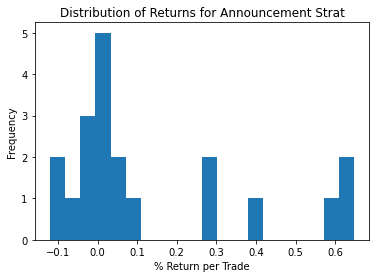

In [49]:
returns = [x-1 for x in sales['pnl_change']]
plt.hist(returns, bins = 20)
plt.title('Distribution of Returns for Announcement Strat')
plt.ylabel('Frequency')
plt.xlabel('% Return per Trade')

Holding Period: 1 Days
# Trades: 20
Avg return: 0.13
Avg std dev: 0.24
Sharpe: 0.56
Total Returns: 8.28


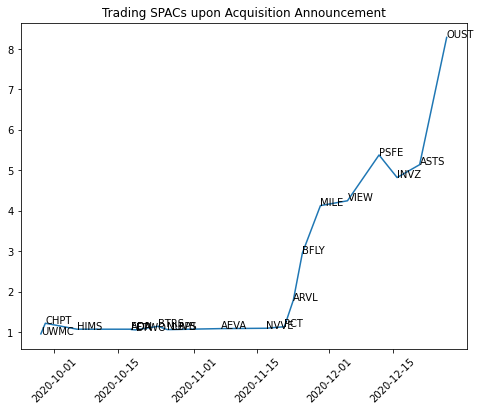

In [73]:
print(f'Holding Period: {holdingperiod} Days')
print(f'# Trades: {len(sales)}')
print(f'Avg return: {round(np.mean(returns),2)}')
print(f'Avg std dev: {round(np.std(returns),2)}')
print(f'Sharpe: {round(np.mean(returns)/np.std(returns),2)}')
print('Total Returns:', round(list(sales["rolling pnl"])[-1],2))
fig = plt.figure(figsize = (8,6))
plt.xticks(rotation = 45)
plt.title('Trading SPACs upon Acquisition Announcement')
plt.plot(sales['Date'],sales['rolling pnl'])

for (x,y, label) in zip(list(sales['Date']), list(sales['rolling pnl']),list(sales['ticker'])):
    plt.text(x,y, label)

## Calculating the distribution of time from announcement to closing

In [105]:
announcements_df = pd.read_csv('filtered_announced_data.csv', index_col = 0)
announcements_df['Announced'] = pd.to_datetime(announcements_df['Announced'])
announcements_df['Closed'] = pd.to_datetime(announcements_df['Closed'])
announcements_df.head()

,Ticker,Announced,Closed
0,ASTS,2020-12-16,2021-04-06
1,INVZ,2020-12-11,2021-04-05
2,FOA,2020-10-13,2021-04-01
3,PSFE,2020-12-07,2021-03-30
4,ARVL,2020-11-18,2021-03-24


In [106]:
closing_periods = announcements_df['Closed']- announcements_df['Announced']

In [107]:
# Removes the 20 tickers that had NaT for their closing period
closing_periods_filtered = closing_periods[pd.notnull(closing_periods)].dt.days
# Removing the outliers that had negative closing periods
closing_periods_positive = [x for x in closing_periods_filtered if x > 0]

Text(0.5, 0, '# Days')

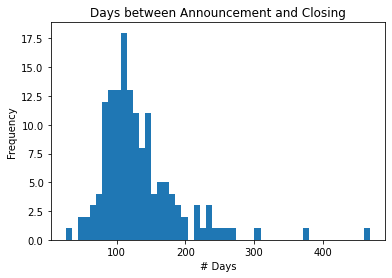

In [111]:
plt.hist(list(closing_periods_positive),bins = 50)
plt.title('Days between Announcement and Closing')
plt.ylabel('Frequency')
plt.xlabel('# Days')

In [77]:
# date = '2020-12-19'


# date = pd.to_datetime(date)
# trading_days= list(prices_df[['Date',ticker]].dropna(axis = 0)['Date'].values)
# if date in trading_days:
#     trade_date = date
# else:
#     trade_date = nearest(trading_days, date)
#     trade_date = pd.to_datetime(trade_date)
#     print(f'{date.date()} not in data, so {trade_date.date()} used instead')

# date_filter = (prices_df['Date'] ==  trade_date)
# price = prices_df[date_filter][ticker].values[0]
# print(ticker, trade_date, price)
# # return price

2020-12-19 not in data, so 2020-12-18 used instead
INVZ 2020-12-18 00:00:00 11.6
